In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.emulator as em
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors as pr
import matplotlib.pyplot as plt
import scipy as sc
import lbg_forecast.selection as sel
import lbg_forecast.noise as noise
import lbg_forecast.colour_cuts as cuts

In [3]:
# initalise fsps emulator
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [4]:
# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0

bins = np.arange(minz, maxz, dz)

In [5]:
bounds = hyp.hyperparameter_tighter()
nhypersamples = 1
hyperparameter_samples = np.vsplit(hyp.sample_prior_parameters(nhypersamples, bounds[0], bounds[1]), nhypersamples)

In [6]:
prior_data = pr.preload_prior_data(zmax=7.0)

In [7]:
nsamples = 200000
nzs = []
spsp = []
for row in hyperparameter_samples:
    sps_params = pop.generate_sps_parameters(nsamples, row[0], prior_data, uniform_redshift_mass=False, uniform_logf=False)
    source_photometry = model.mimic_photometry(sps_params, 1000)

    #lbg_nzs = nz.simulate_nzs(sps_params, model, 1000)
    #nzs.append(lbg_nzs)
    #spsp.append(sps_params)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


In [8]:
colours = sel.calculate_colours(source_photometry)
umg = colours[:, 0]
gmr = colours[:, 1]
redshifts = sps_params[:, 0]

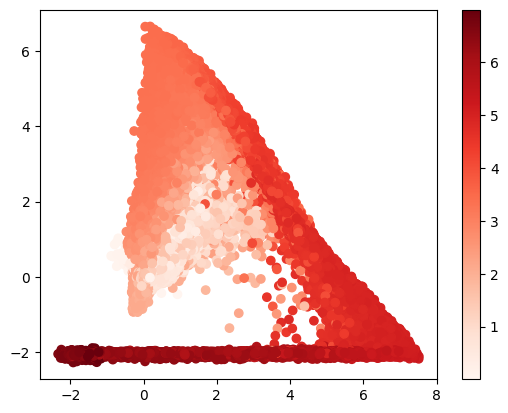

In [9]:
plt.scatter(gmr, umg, c=redshifts, cmap='Reds')
plt.colorbar()

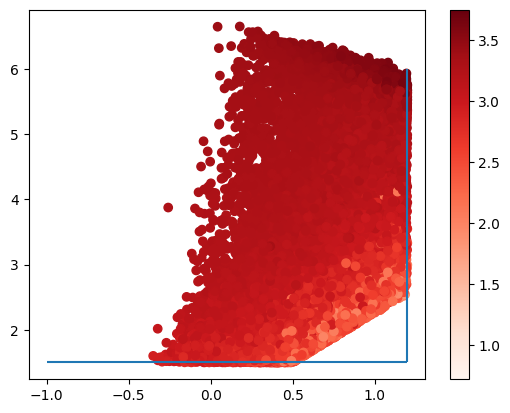

In [10]:
umg_lbgs = umg[cuts.sources_inside_u_cuts(umg, gmr)]
gmr_lbgs = gmr[cuts.sources_inside_u_cuts(umg, gmr)]
redshifts_lbgs = redshifts[cuts.sources_inside_u_cuts(umg, gmr)]
plt.hlines(1.5, -1.0, 1.2)
plt.vlines(1.2, 1.5, 6.0)
plt.scatter(gmr_lbgs, umg_lbgs, c=redshifts_lbgs, cmap='Reds')
plt.colorbar()

Text(0.5, 0, 'z')

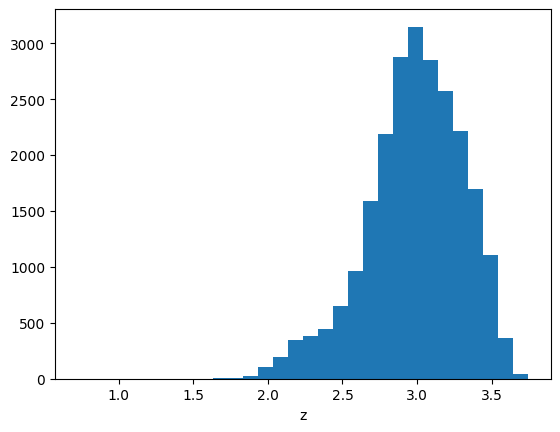

In [11]:
plt.hist(redshifts_lbgs[0], bins=30)
plt.xlabel('z')

(139,)
(139,)


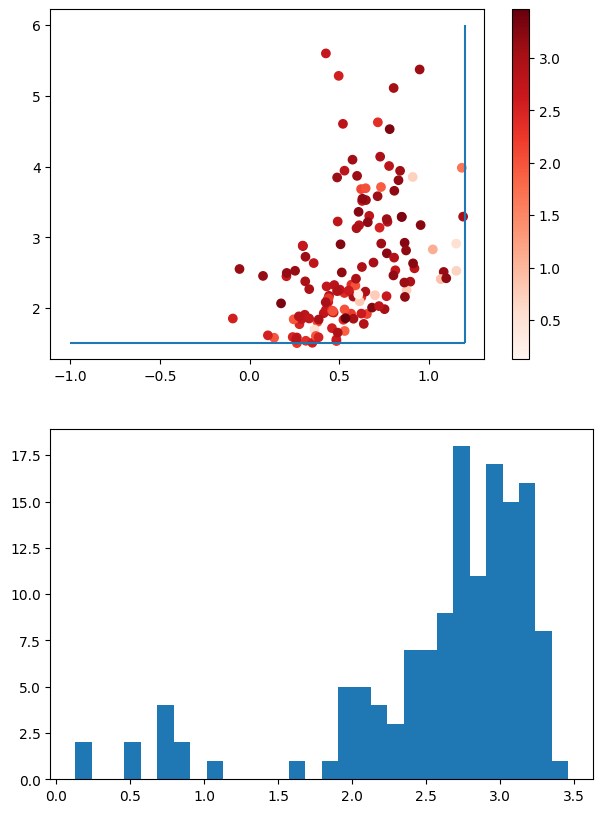

In [13]:
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize=(7, 10))

all_dropouts_mags = noise.get_noisy_magnitudes(sps_params, source_photometry, random_state=np.random.randint(0, 100000))
all_dropouts_colours = cuts.colours(all_dropouts_mags)
u_data, g_data, r_data = cuts.apply_cuts_to_colours(all_dropouts_colours)
nzs = nz.build_redshift_distribution_samples_object(u_data, g_data, r_data)

u_params, u_colours = u_data

umg = np.squeeze(u_colours[:, :, 0])
gmr = np.squeeze(u_colours[:, :, 1])
u_redshifts = nzs[0]


print(u_redshifts.shape)
print(umg.shape)

axes[0].hlines(1.5, -1.0, 1.2)
axes[0].vlines(1.2, 1.5, 6.0)
plot1 = axes[0].scatter(gmr, umg, c=u_redshifts, cmap='Reds')
fig.colorbar(plot1)

plot2 = axes[1].hist(u_redshifts, bins=30)